In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re



In [152]:
# Load and clean data
tweets_df = pd.read_csv('tweetsdata.csv')
tweets_df.columns = tweets_df.columns.str.strip()  # Fix column whitespace


C:\Users\GR_Admin\AppData\Local\Temp\ipykernel_40940\198296058.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets_df = pd.read_csv('tweetsdata.csv')


In [153]:
# Preprocess text column
tweets_df['text'] = tweets_df['text'].fillna('')  # Handle NaN values
tweets_df['text'] = tweets_df['text'].astype(str)  # Force string type

In [154]:
# Diagnostic check
print("\nData Validation:")
print(f"NaN values in 'text': {tweets_df['text'].isna().sum()}")
print(f"Sample non-string values: {tweets_df[tweets_df['text'] == ''].shape[0]} empty strings")



Data Validation:
NaN values in 'text': 0
Sample non-string values: 1 empty strings


In [155]:
# hashtag extraction with error handling
def extract_hashtags_safe(text):
    try:
        return re.findall(r'#\w+', text.lower())
    except AttributeError:
        return []
    except Exception as e:
        print(f"Unexpected error: {e}")
        return []

In [156]:
# Apply safe hashtag extraction
tweets_df['hashtags'] = tweets_df['text'].apply(extract_hashtags_safe)
tweets_df['hashtag_count'] = tweets_df['hashtags'].apply(len)


In [157]:
# Basic statistics
print(f"Total Tweets: {len(tweets_df)}")
print(f"Unique Users: {tweets_df['UserID'].nunique()}")
print(f"Average Reach: {tweets_df['Reach'].mean():.1f}")
print(f"Most Active Hour: {tweets_df['Hour'].mode()[0]}:00")

Total Tweets: 100001
Unique Users: 33213
Average Reach: 8542.4
Most Active Hour: 11.0:00


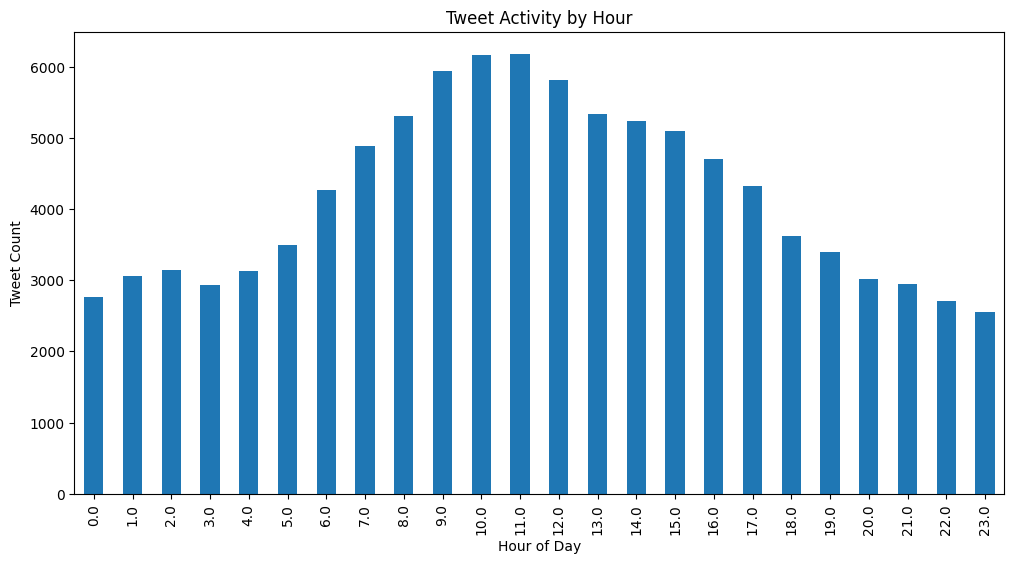

In [158]:
# Rest of the EDA code with visualization (unchanged but now safe to run)
# Temporal Analysis
plt.figure(figsize=(12,6))
tweets_df['Hour'].value_counts().sort_index().plot(kind='bar')
plt.title('Tweet Activity by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Tweet Count')
plt.show()

In [159]:
# Hashtag frequency analysis (now safe)
all_hashtags = [h for sublist in tweets_df['hashtags'] for h in sublist]
top_hashtags = Counter(all_hashtags).most_common(10)

---------------

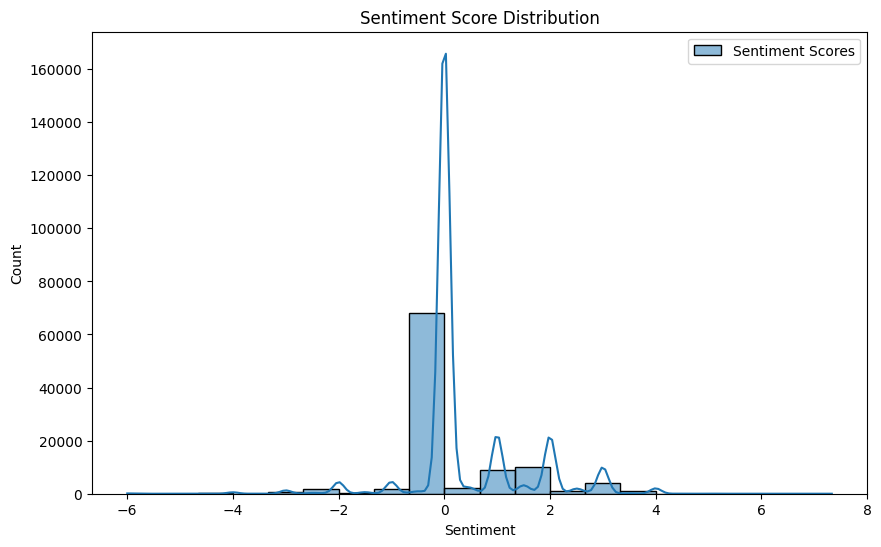

In [160]:
# Sentiment Distribution
plt.figure(figsize=(10,6))
sns.histplot(tweets_df['Sentiment'], bins=20, kde=True, label='Sentiment Scores')
plt.title('Sentiment Score Distribution')
plt.legend() 
plt.show()

In [161]:
# Core analysis functions
def analyze_hashtag_metrics(df):
    """Calculate key metrics for each hashtag"""
    metrics = {
        'count': df.size,
        'avg_sentiment': df['Sentiment'].mean(),
        'total_reach': df['Reach'].sum(),
        'avg_retweets': df['RetweetCount'].mean(),
        'gender_distribution': df['Gender'].value_counts().to_dict()
    }
    return pd.Series(metrics)


In [162]:

# Top hashtag analysis
all_hashtags = [h for sublist in tweets_df['hashtags'] for h in sublist]
top_hashtags = [tag for tag, _ in Counter(all_hashtags).most_common(15)]


In [163]:

# Multi-dimensional analysis
analysis = tweets_df.explode('hashtags').groupby('hashtags').apply(analyze_hashtag_metrics)
country_analysis = tweets_df.explode('hashtags').groupby(['Country', 'hashtags']).size().unstack(fill_value=0)
time_analysis = tweets_df.explode('hashtags').groupby(['Hour', 'hashtags']).size().unstack(fill_value=0)


C:\Users\GR_Admin\AppData\Local\Temp\ipykernel_40940\2167631596.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  analysis = tweets_df.explode('hashtags').groupby('hashtags').apply(analyze_hashtag_metrics)


In [164]:

# Output results
print("Top 10 Hashtag Metrics:")
print(analysis.loc[top_hashtags].sort_values('count', ascending=False))

print("\nCountry Distribution:")
print(country_analysis[top_hashtags].sum().sort_values(ascending=False))

print("\nPeak Engagement Hours:")
print(time_analysis[top_hashtags].idxmax())


Top 10 Hashtag Metrics:
                  count  avg_sentiment  total_reach  avg_retweets  \
hashtags                                                            
#aws             451486       0.431442  157726482.0      5.164357   
#cloud           112455       0.335204   34084032.0      2.920030   
#job              74460       0.236639    2055834.0      0.172603   
#jobs             58582       0.083464    5274703.0      0.174115   
#bigdata          36720       0.367975   36386605.0      9.972222   
#devops           32079       0.388244   10387640.0      1.953895   
#cloudcomputing   30634       0.287923   20335085.0     13.043840   
#azure            26299       0.350890    4924045.0      3.679379   
#amazon           26112       0.203171    4836444.0      1.076823   
#jobsearch        25704       0.007804    1083628.0      0.062169   
#iot              21148       0.597983   11826841.0      7.003215   
#tech             19686       0.321390    5110555.0      3.354922   
#seattle  

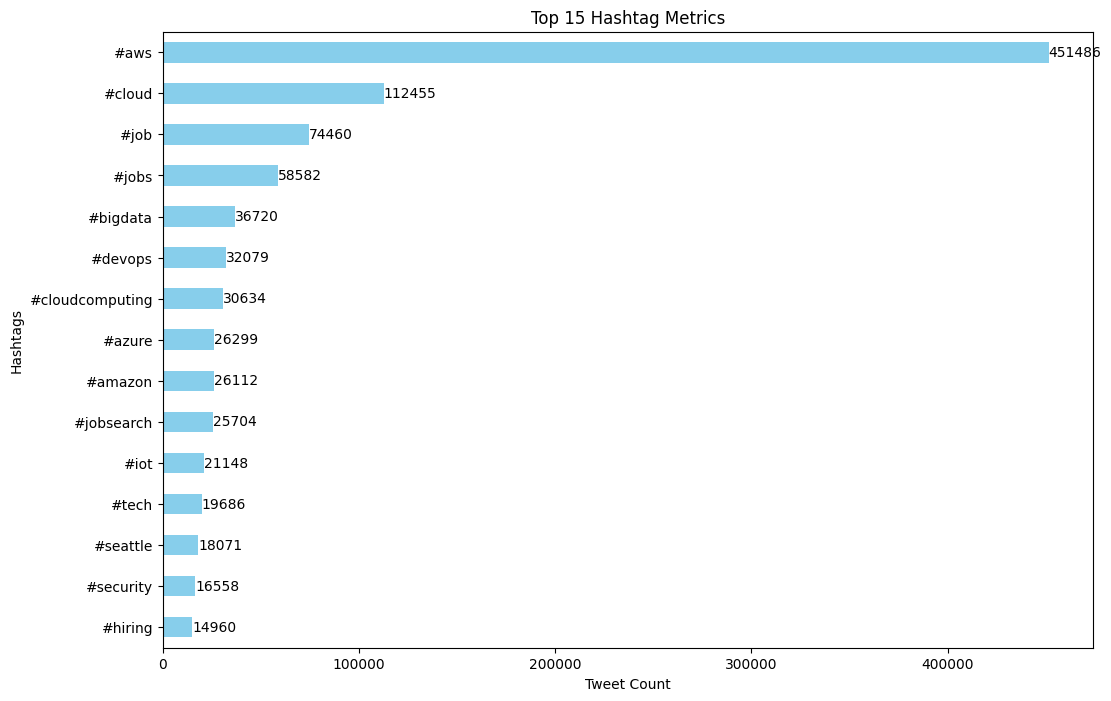

In [165]:
# Top 15 Hashtag Metrics in Horizontal Bar Chart with Counts
top_15_hashtags = analysis.loc[top_hashtags].sort_values('count', ascending=False).head(15)

plt.figure(figsize=(12, 8))
ax = top_15_hashtags['count'].plot(kind='barh', color='skyblue')
plt.title('Top 15 Hashtag Metrics')
plt.xlabel('Tweet Count')
plt.ylabel('Hashtags')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest count at the top

# Add counts to the bars
for index, value in enumerate(top_15_hashtags['count']):
    plt.text(value, index, str(value), va='center')  # Display the count at the end of each bar

plt.show()

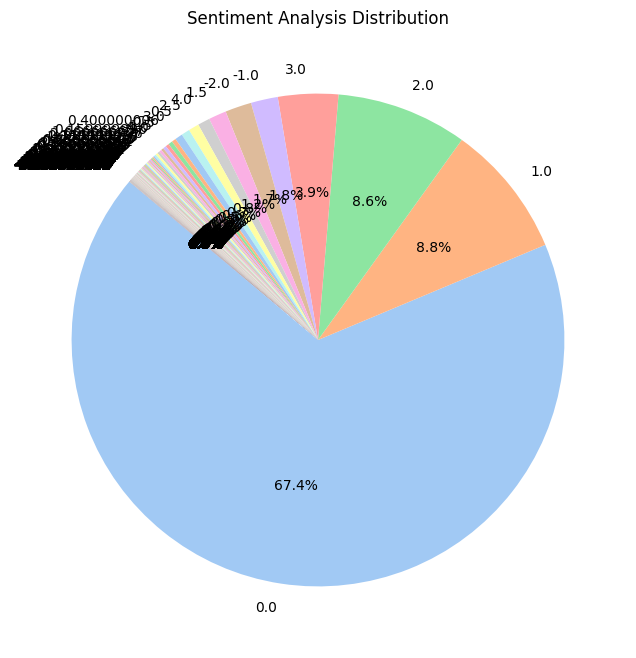

In [166]:
# Pie Chart for Sentiment Analysis
sentiment_counts = tweets_df['Sentiment'].value_counts()  # Count occurrences of each sentiment
labels = sentiment_counts.index  # Sentiment categories
sizes = sentiment_counts.values  # Corresponding counts

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title('Sentiment Analysis Distribution')
plt.show()

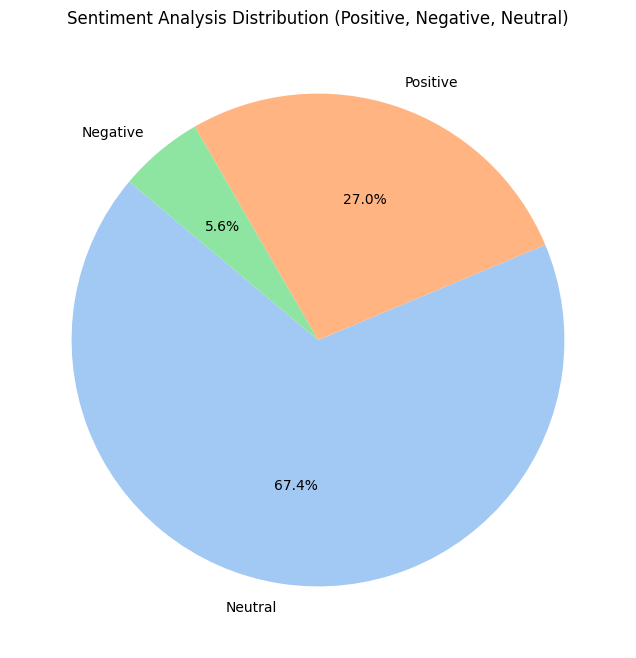

In [167]:
# Map sentiment scores to Positive, Negative, and Neutral categories
def categorize_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

tweets_df['SentimentCategory'] = tweets_df['Sentiment'].apply(categorize_sentiment)

# Count occurrences of each sentiment category
sentiment_counts = tweets_df['SentimentCategory'].value_counts()
labels = sentiment_counts.index  # Sentiment categories
sizes = sentiment_counts.values  # Corresponding counts

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title('Sentiment Analysis Distribution (Positive, Negative, Neutral)')
plt.show()